In [2]:
import pandas as pd

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

customers_head = customers.head()
products_head = products.head()
transactions_head = transactions.head()

customers_info = customers.info()
products_info = products.info()
transactions_info = transactions.info()

customers_head, products_head, transactions_head, customers_info, products_info, transactions_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067   2024-04-25 7:38:55    

In [13]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

customer_transactions = transactions.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    transaction_count=pd.NamedAgg(column='TransactionID', aggfunc='count'),
    avg_transaction_value=pd.NamedAgg(column='TotalValue', aggfunc='mean'),
    unique_products=pd.NamedAgg(column='ProductID', aggfunc='nunique'),
    first_purchase=pd.NamedAgg(column='TransactionDate', aggfunc='min'),
    last_purchase=pd.NamedAgg(column='TransactionDate', aggfunc='max')
).reset_index()

customer_transactions['days_since_last_purchase'] = (pd.Timestamp.now() - customer_transactions['last_purchase']).dt.days
customer_transactions['customer_tenure'] = (pd.Timestamp.now() - customer_transactions['first_purchase']).dt.days

customers_enriched = pd.merge(customers, customer_transactions, on='CustomerID', how='left')

customers_enriched.head()

,CustomerID,CustomerName,Region,SignupDate,total_spent,transaction_count,avg_transaction_value,unique_products,first_purchase,last_purchase,days_since_last_purchase,customer_tenure
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0,670.904,5.0,2024-01-19 03:12:55,2024-11-02 17:04:16,86.0,374.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0,465.685,4.0,2024-02-28 07:44:21,2024-12-03 01:41:41,56.0,334.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0,681.345,4.0,2024-02-18 02:50:37,2024-08-24 18:54:04,156.0,344.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0,669.360,8.0,2024-02-28 10:16:35,2024-12-23 14:13:52,35.0,334.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0,678.080,3.0,2024-03-15 04:08:59,2024-11-04 00:30:22,85.0,318.0


C:\Users\khush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\khush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\khush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\khush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

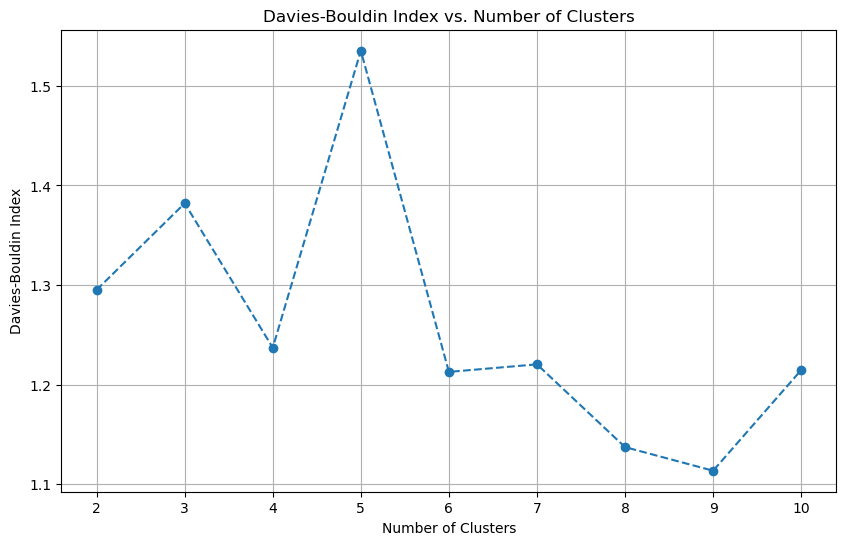

9

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


features = ['total_spent', 'transaction_count', 'avg_transaction_value',
            'unique_products', 'days_since_last_purchase', 'customer_tenure']


customers_enriched[features] = customers_enriched[features].fillna(0)


scaler = StandardScaler()
normalized_features = scaler.fit_transform(customers_enriched[features])


db_index_scores = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(normalized_features)
    db_index = davies_bouldin_score(normalized_features, clusters)
    db_index_scores.append(db_index)


plt.figure(figsize=(10, 6))
plt.plot(cluster_range, db_index_scores, marker='o', linestyle='--')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(cluster_range)
plt.grid()
plt.show()

optimal_clusters = cluster_range[db_index_scores.index(min(db_index_scores))]
optimal_clusters



C:\Users\khush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


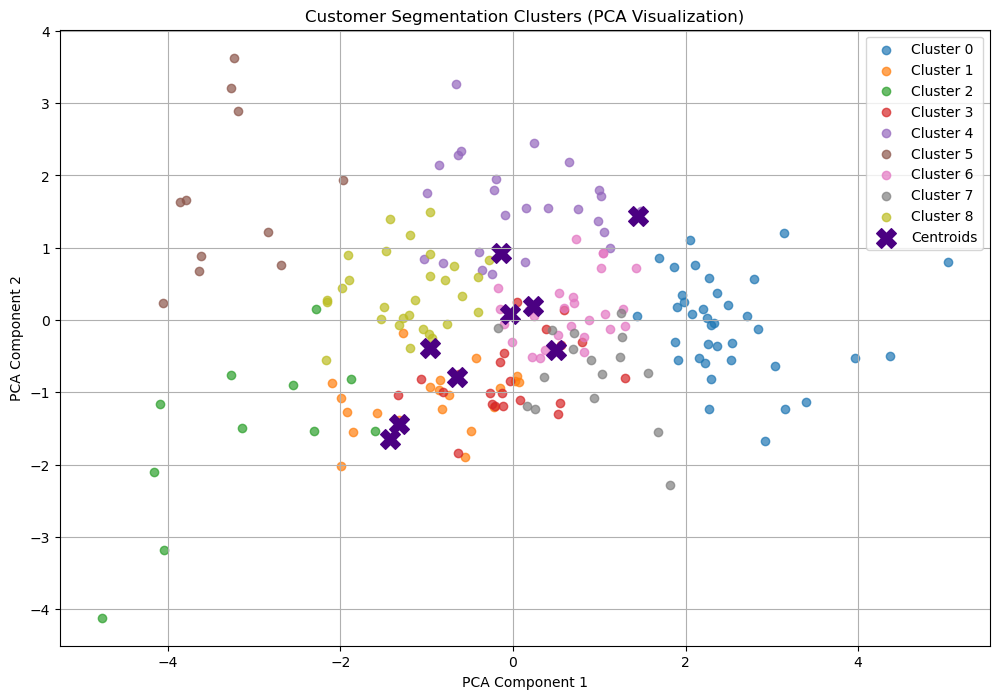

,CustomerID,Cluster,total_spent,transaction_count,unique_products
0,C0001,6,3354.52,5.0,5.0
1,C0002,1,1862.74,4.0,4.0
2,C0003,8,2725.38,4.0,4.0
3,C0004,0,5354.88,8.0,8.0
4,C0005,8,2034.24,3.0,3.0


In [36]:
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
customers_enriched['Cluster'] = kmeans_final.fit_predict(normalized_features)

pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(normalized_features)

customers_enriched['PCA1'] = pca_features[:, 0]
customers_enriched['PCA2'] = pca_features[:, 1]

plt.figure(figsize=(12, 8))
for cluster in range(optimal_clusters):
    cluster_data = customers_enriched[customers_enriched['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', alpha=0.7)

plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1],
            color='indigo', marker='X', s=200, label='Centroids')

plt.title('Customer Segmentation Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

customers_enriched[['CustomerID', 'Cluster', 'total_spent', 'transaction_count', 'unique_products']].head()

In [23]:
# 1. Data Preprocessing - Merging customer profile and transaction data
merged_df = pd.merge(transactions, customers, on='CustomerID', how='inner')



In [25]:
# 2. Feature Engineering: Creating relevant features from transaction data
customer_metrics = merged_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count')
).reset_index()

# Adding customer profile data (region, signup date)
customer_profile = customers[['CustomerID', 'Region']]
customer_data = pd.merge(customer_metrics, customer_profile, on='CustomerID', how='left')

In [26]:
# 3. Convert categorical variable ('Region') to dummy variables (one-hot encoding)
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)



In [27]:
# 4. Normalize data (standard scaling)
scaler = StandardScaler()
features = ['total_spent', 'transaction_count'] + [col for col in customer_data.columns if 'Region_' in col]
customer_data_scaled = scaler.fit_transform(customer_data[features])

In [30]:
# 5. Clustering using K-Means (with 2 to 10 clusters)
db_indexes = []
inertia_values = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Added n_init=10
    kmeans.fit(customer_data_scaled)
    
    # Davies-Bouldin Index
    db_index = davies_bouldin_score(customer_data_scaled, kmeans.labels_)
    db_indexes.append(db_index)
    
    # Store inertia (optional for evaluation)
    inertia_values.append(kmeans.inertia_)

C:\Users\khush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\khush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\khush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\khush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [32]:
# Find the best k based on Davies-Bouldin Index (lower is better)
import numpy as np
best_k = np.argmin(db_indexes) + 2  # Adding 2 because range starts from 2
print(f"Best k based on Davies-Bouldin Index: {best_k}")

# Fit KMeans with the best k
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)  # Added n_init=10
customer_data['Cluster'] = kmeans_final.fit_predict(customer_data_scaled)

# 6. PCA for visualization (reduce to 2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_data_scaled)
customer_data['PCA1'], customer_data['PCA2'] = pca_components[:, 0], pca_components[:, 1]

Best k based on Davies-Bouldin Index: 10


C:\Users\khush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


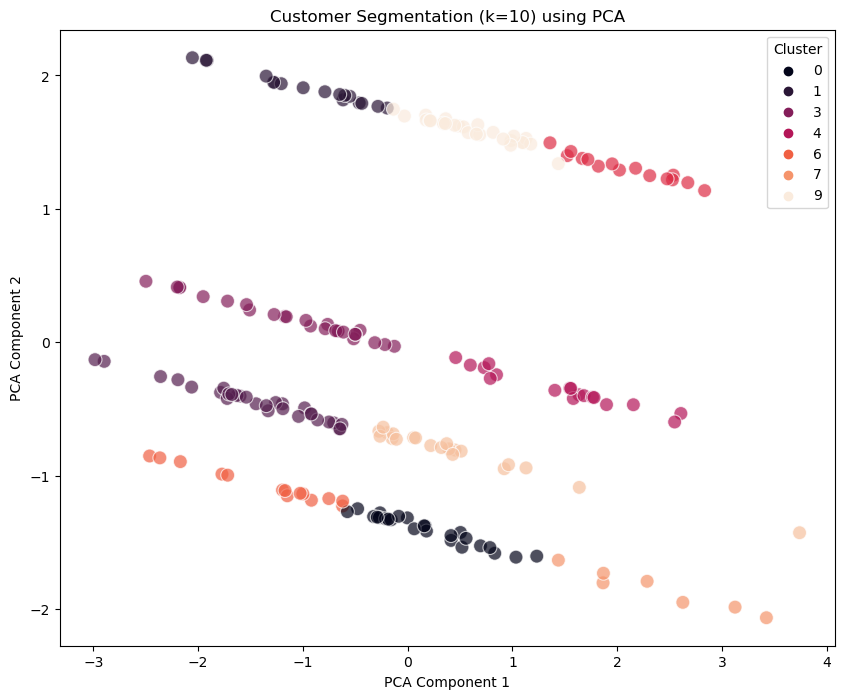

In [38]:
# 7. Plotting the clusters
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='rocket', s=100, alpha=0.7)
plt.title(f'Customer Segmentation (k={best_k}) using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()